In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange

## Environments for 1d and 2d grid world

In [2]:
class Grid1d:
    def __init__(self):
        self._trap = 0
        self._goal = 5
        self._player = 2
        self._reward = [-1.01, -0.01, -0.01, -0.01, -0.01, 0.99]
        self._action2move = [-1, 1]
        self._terminated = False

    def reset(self):
        self._player = 2
        self._terminated = False
        return self._player, 0.0, self._terminated

    def transition(self, action):
        assert not self._terminated
        move = self._action2move[action]
        self._player += move
        reward = self._reward[self._player]
        self._terminated = self._player in [self._trap, self._goal]
        return self._player, reward, self._terminated

In [3]:
class Grid2d:
    def __init__(self):
        self._trap = [1, 3]
        self._goal = [0, 3]
        self._obstacle = [1, 1]
        self._player = [2, 0]
        self._reward = [[-0.01, -0.01, -0.01, 0.99],
                        [-0.01, -0.01, -0.01, -1.01],
                        [-0.01, -0.01, -0.01, -0.01]]
        self._terminated = False
        self._transition_probs = [[0.8, 0.1, 0.0, 0.1],
                                  [0.1, 0.8, 0.1, 0.0],
                                  [0.0, 0.1, 0.8, 0.1],
                                  [0.1, 0.0, 0.1, 0.8]]
        self._actions = [0, 1, 2, 3]
        self._action2move = [[1, 0],    #DOWN
                             [0, 1],    #RIGHT
                             [-1, 0],   #UP
                             [0, -1]]   #LEFT

    def reset(self):
        self._player = [2, 0]
        self._terminated = False
        return self._player, 0.0, self._terminated

    def transition(self, action):
        assert not self._terminated
        action = np.random.choice(self._actions, size=1, p=self._transition_probs[action]).item()
        move = self._action2move[action]
        new_pos = [
            min(2, max(0, self._player[0] + move[0])),
            min(3, max(0, self._player[1] + move[1]))
        ]
        if new_pos[0] == self._obstacle[0] and new_pos[1] == self._obstacle[1]:
            new_pos = self._player
        self._player = list(new_pos)
        reward = self._reward[self._player[0]][self._player[1]]
        trapped = self._player[0] == self._trap[0] and self._player[1] == self._trap[1]
        won = self._player[0] == self._goal[0] and self._player[1] == self._goal[1]
        self._terminated = trapped or won
        return self._player, reward, self._terminated

## Agents for 1d and 2d grid world

In [4]:
class Agent1d:
    def __init__(self, gamma, alpha, epsilon):
        self._gamma = gamma
        self._alpha = alpha
        self._epsilon = epsilon

        self._q = np.zeros([6, 2])

        self._previous_state = -1
        self._previous_action = -1

    def reset(self):
        self._previous_state = -1
        self._previous_action = -1
    
    def exploration_policy(self, state):
        self._previous_state = state
        if np.random.rand(1) < self._epsilon:        
            action = np.random.randint(low=0, high=2, dtype=np.int8).item()
        else:
            action = self.policy(state)
        self._previous_action = action
        return action

    def policy(self, state):
        action = np.argmax(self._q[state]).item()
        return action

    def update(self, state, reward):
        q_previous = self._q[self._previous_state, self._previous_action].item()
        q_current = np.max(self._q[state]).item()
        delta = reward + self._gamma * q_current - q_previous
        q_update = q_previous + self._alpha * delta
        self._q[self._previous_state, self._previous_action] = q_update

In [5]:
class Agent2d:
    def __init__(self, gamma, alpha, epsilon):
        self._gamma = gamma
        self._alpha = alpha
        self._epsilon = epsilon

        self._q = np.zeros([3, 4, 4])

        self._previous_state = [-1, -1]
        self._previous_action = -1

    def reset(self):
        self._previous_state = [-1, -1]
        self._previous_action = -1
    
    def exploration_policy(self, state):
        self._previous_state = list(state)
        if np.random.rand(1) < self._epsilon:
            action = np.random.randint(low=0, high=4, dtype=np.int8).item()
        else:
            action = self.policy(state)
        self._previous_action = action
        return action

    def policy(self, state):
        action = np.argmax(self._q[state[0], state[1]]).item()
        return action

    def update(self, state, reward):
        assert self._previous_action in [0, 1, 2, 3] and self._previous_state[0] in [0, 1, 2] and self._previous_state[1] in [0, 1, 2, 3]
        q_previous = self._q[self._previous_state[0], self._previous_state[1], self._previous_action].item()
        q_current = np.max(self._q[state[0], state[1]]).item()
        delta = reward + self._gamma * q_current - q_previous
        q_update = q_previous + self._alpha * delta
        self._q[self._previous_state[0], self._previous_state[1], self._previous_action] = q_update

## Training functions

In [6]:
def epoch(grid, agent, max_steps):
    total_reward = 0.0
    state, reward, terminated = grid.reset()
    agent.reset()
    for i in range(max_steps):
        action = agent.exploration_policy(state)
        state, reward, terminated = grid.transition(action)
        total_reward += reward
        agent.update(state, reward)
        if terminated:
            break
    episode_length = i + 1
    return total_reward, episode_length

In [7]:
def train(grid, agent, episodes, max_steps):
    initial_epsilon = agent._epsilon
    total_reward_array = np.zeros(episodes, dtype=float)
    episode_length_array = np.zeros(episodes, dtype=float)
    for i in trange(episodes):
        total_reward, episode_length = epoch(grid, agent, max_steps)
        agent._epsilon = max(0.0, agent._epsilon - initial_epsilon * 1/(episodes*0.8))
        total_reward_array[i] = total_reward
        episode_length_array[i] = episode_length
    return total_reward_array, episode_length_array

In [8]:
def smooth(measurements, n):
    measurements = np.atleast_2d(measurements)
    measurements = measurements.transpose()
    m = measurements.shape[0]
    smooth_measurements = np.zeros_like(measurements)
    for i in range(m):
        i_minus_n = max(0, i - n)
        i_plus_n = min(m - 1, i + n)
        smooth_measurements[i] = np.mean(measurements[i_minus_n: i_plus_n], axis=0)
    smooth_measurements = smooth_measurements.transpose()
    smooth_measurements = smooth_measurements.squeeze()
    return smooth_measurements

## Demo for 1d

In [9]:
grid1d = Grid1d()
agent1d = Agent1d(gamma=0.9, alpha=0.9, epsilon=1.0)

In [10]:
episodes_1d = 1000
max_steps_1d = 20

In [11]:
total_reward_1d, episode_length_1d = train(grid1d, agent1d, episodes_1d, max_steps_1d)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
highest_reward_1d = 0.97
least_steps_1d = 3
smoothing_1d = 50

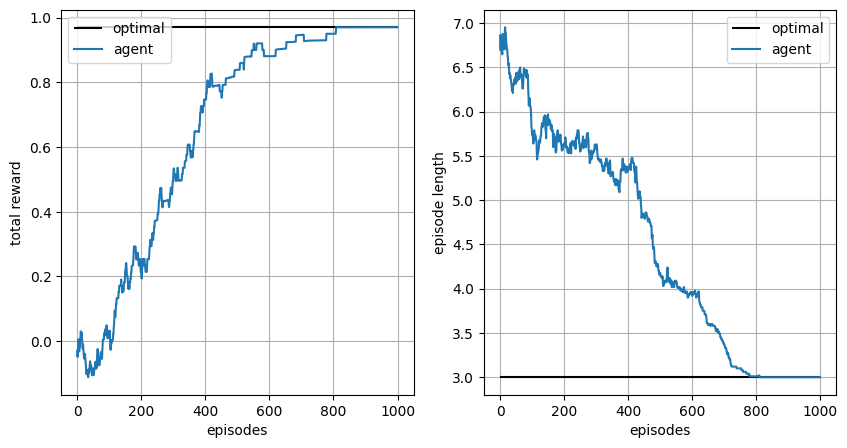

In [13]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.grid()
plt.hlines(highest_reward_1d, 0, episodes_1d, color='black', label='optimal')
plt.plot(smooth(total_reward_1d, smoothing_1d), label='agent')
plt.ylabel('total reward')
plt.xlabel('episodes')
plt.legend()

plt.subplot(122)
plt.grid()
plt.hlines(least_steps_1d, 0, episodes_1d, color='black', label='optimal')
plt.plot(smooth(episode_length_1d, smoothing_1d), label='agent')
plt.ylabel('episode length')
plt.xlabel('episodes')
plt.legend()

plt.show()

## Demo for 2d

In [14]:
grid2d = Grid2d()
agent2d = Agent2d(gamma=0.9, alpha=0.9, epsilon=1.0)

In [15]:
episodes_2d = 5000
max_steps_2d = 50

In [16]:
total_reward_2d, episode_length_2d = train(grid2d, agent2d, episodes_2d, max_steps_2d)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [17]:
highest_reward_2d = 0.95
least_steps_2d = 5
smoothing_2d = 200

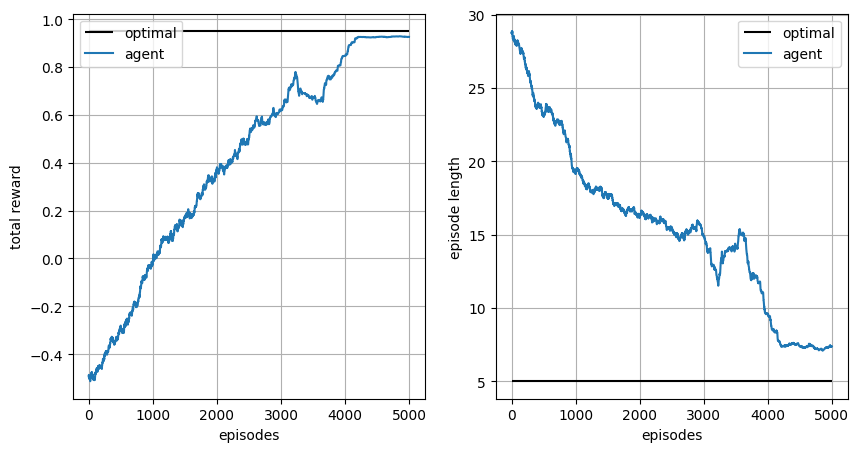

In [18]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.grid()
plt.hlines(highest_reward_2d, 0, episodes_2d, color='black', label='optimal')
plt.plot(smooth(total_reward_2d, smoothing_2d), label='agent')
plt.ylabel('total reward')
plt.xlabel('episodes')
plt.legend()

plt.subplot(122)
plt.grid()
plt.hlines(least_steps_2d, 0, episodes_2d, color='black', label='optimal')
plt.plot(smooth(episode_length_2d, smoothing_2d), label='agent')
plt.ylabel('episode length')
plt.xlabel('episodes')
plt.legend()

plt.show()

## Impact of hyperparameters on 1d grid

# !!! 

The following experiments take long to finish. Only rerun them if necessary.

In [19]:
alphas = np.linspace(0.1, 1.0, 10)
gammas = np.linspace(0.0, 1.0, 11)
epsilons = np.linspace(0.0, 1.0, 11)

In [20]:
colors10 = [plt.get_cmap('rainbow')(i/9) for i in range(10)]
colors11 = [plt.get_cmap('rainbow')(i/10) for i in range(11)]

In [21]:
try:
    total_reward_smooth = np.load('total_reward_smooth_1d.npy')
except FileNotFoundError:
    total_reward_array = np.zeros([len(alphas), len(gammas), len(epsilons), episodes_1d])
    
    grid = Grid1d()
    for i in trange(len(alphas)):
        alpha = alphas[i]
        for j in range(len(gammas)):
            gamma = gammas[j]
            for k in range(len(epsilons)):
                epsilon = epsilons[k]
                
                agent = Agent1d(gamma, alpha, epsilon)
                total_reward, _ = train(grid, agent, episodes_1d, max_steps_1d)
                total_reward_array[i, j, k, :] = total_reward

    total_reward_smooth = smooth(total_reward_array, smoothing_1d)

    np.save('total_reward_smooth_1d.npy', total_reward_smooth)

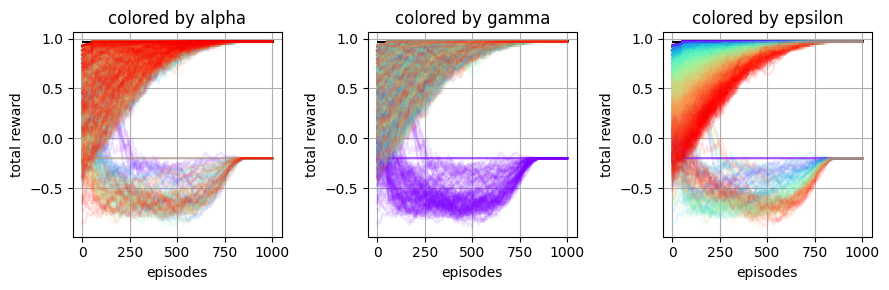

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

axes[0].set_title('colored by alpha')
axes[1].set_title('colored by gamma')
axes[2].set_title('colored by epsilon')

for ax in axes:
    ax.grid()
    ax.hlines(highest_reward_1d, 0, episodes_1d, color='black', label='optimal')
    ax.set_xlabel('episodes')
    ax.set_ylabel('total reward')

for i in range(10):
    for j in range(11):
        for k in range(11):
            axes[0].plot(total_reward_smooth[i, j, k], label=f'agent {i+1}', c=colors10[i], alpha=0.1)
            axes[1].plot(total_reward_smooth[i, j, k], label=f'agent {i+1}', c=colors11[j], alpha=0.1)
            axes[2].plot(total_reward_smooth[i, j, k], label=f'agent {i+1}', c=colors11[k], alpha=0.1)

fig.tight_layout()
plt.show()

Here we see that the method converges for all used values of gamma as long as they are greater than zero. This makes sense since the value function will only learn the immediate reward and disregard long term value. Furthermore, convergence is faster, the smaller the initial epsilon.

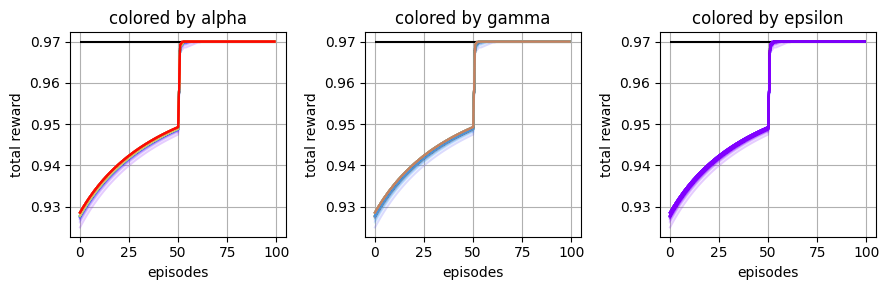

In [23]:
cap_at = 100

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

axes[0].set_title('colored by alpha')
axes[1].set_title('colored by gamma')
axes[2].set_title('colored by epsilon')

for ax in axes:
    ax.grid()
    ax.hlines(highest_reward_1d, 0, cap_at, color='black', label='optimal')
    ax.set_xlabel('episodes')
    ax.set_ylabel('total reward')

for i in range(10):
    for j in range(1, 11):
        for k in range(1):
            axes[0].plot(total_reward_smooth[i, j, k, :cap_at], label=f'agent {i+1}', c=colors10[i], alpha=0.2)
            axes[1].plot(total_reward_smooth[i, j, k, :cap_at], label=f'agent {i+1}', c=colors11[j], alpha=0.2)
            axes[2].plot(total_reward_smooth[i, j, k, :cap_at], label=f'agent {i+1}', c=colors11[k], alpha=0.2)

fig.tight_layout()
plt.show()

We see that in this simple and deterministic environment the agent is able to learn the optimal policy even without an exploration policy. (Already after about 50 epochs.)

## Impact of hyperparameters on 2d grid

In [24]:
try:
    total_reward_smooth = np.load('total_reward_smooth_2d.npy')
except FileNotFoundError:
    total_reward_array = np.zeros([len(alphas), len(gammas), len(epsilons), episodes_2d])
    
    grid = Grid2d()
    for i in trange(len(alphas)):
        alpha = alphas[i]
        for j in range(len(gammas)):
            gamma = gammas[j]
            for k in range(len(epsilons)):
                epsilon = epsilons[k]
                
                agent = Agent2d(gamma, alpha, epsilon)
                total_reward, _ = train(grid, agent, episodes_2d, max_steps_2d)
                total_reward_array[i, j, k, :] = total_reward
    
    total_reward_smooth = smooth(total_reward_array, smoothing_2d)

    np.save('total_reward_smooth_2d.npy', total_reward_smooth)

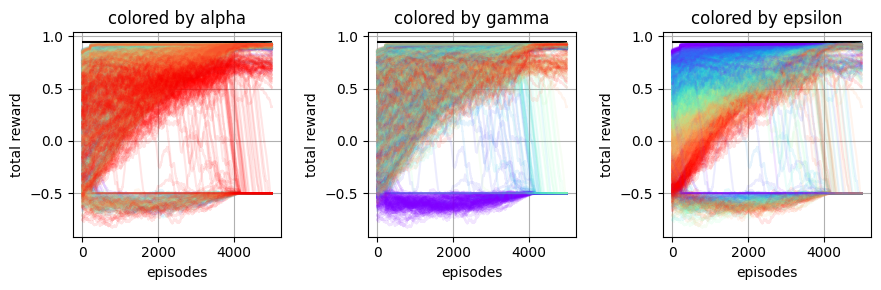

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

axes[0].set_title('colored by alpha')
axes[1].set_title('colored by gamma')
axes[2].set_title('colored by epsilon')

for ax in axes:
    ax.grid()
    ax.hlines(highest_reward_2d, 0, episodes_2d, color='black', label='optimal')
    ax.set_xlabel('episodes')
    ax.set_ylabel('total reward')

for i in range(10):
    for j in range(11):
        for k in range(11):
            axes[0].plot(total_reward_smooth[i, j, k], label=f'agent {i+1}', c=colors10[i], alpha=0.1)
            axes[1].plot(total_reward_smooth[i, j, k], label=f'agent {i+1}', c=colors11[j], alpha=0.1)
            axes[2].plot(total_reward_smooth[i, j, k], label=f'agent {i+1}', c=colors11[k], alpha=0.1)

fig.tight_layout()
plt.show()

We observe similar behavior as in the 1d Grid. Therefore, we sort out values for gamma of zero and for epsilon only keep zero. We also see, that for alpha equal one, we have runs which fail towards the end. We omit values for alpha of one.

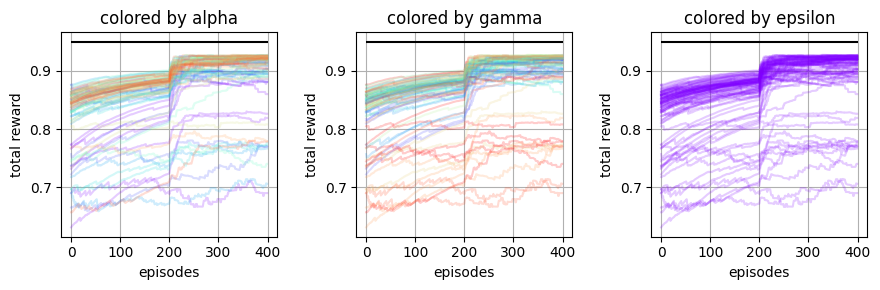

In [26]:
cap_at = 400

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

axes[0].set_title('colored by alpha')
axes[1].set_title('colored by gamma')
axes[2].set_title('colored by epsilon')

for ax in axes:
    ax.grid()
    ax.hlines(highest_reward_2d, 0, cap_at, color='black', label='optimal')
    ax.set_xlabel('episodes')
    ax.set_ylabel('total reward')

for i in range(9):
    for j in range(1, 11):
        for k in range(1):
            axes[0].plot(total_reward_smooth[i, j, k, :cap_at], label=f'agent {i+1}', c=colors10[i], alpha=0.2)
            axes[1].plot(total_reward_smooth[i, j, k, :cap_at], label=f'agent {i+1}', c=colors11[j], alpha=0.2)
            axes[2].plot(total_reward_smooth[i, j, k, :cap_at], label=f'agent {i+1}', c=colors11[k], alpha=0.2)

fig.tight_layout()
plt.show()

Here we see in more detail that in general, high values for gamma don't perform well. We keep only values for gamma of 0.5.

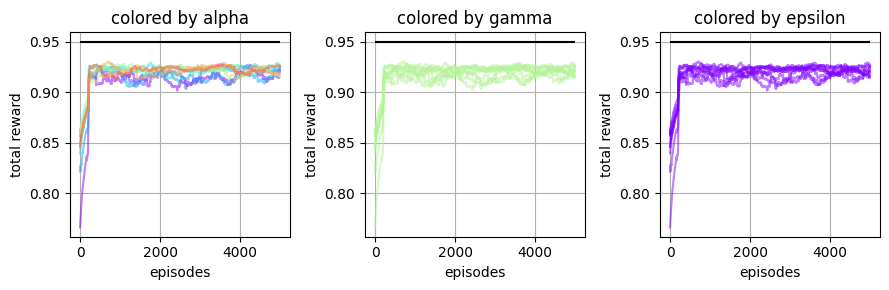

In [27]:
cap_at = 5000

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

axes[0].set_title('colored by alpha')
axes[1].set_title('colored by gamma')
axes[2].set_title('colored by epsilon')

for ax in axes:
    ax.grid()
    ax.hlines(highest_reward_2d, 0, cap_at, color='black', label='optimal')
    ax.set_xlabel('episodes')
    ax.set_ylabel('total reward')

for i in range(9):
    for j in range(6, 7):
        for k in range(1):
            axes[0].plot(total_reward_smooth[i, j, k, :cap_at], label=f'agent {i+1}', c=colors10[i], alpha=0.5)
            axes[1].plot(total_reward_smooth[i, j, k, :cap_at], label=f'agent {i+1}', c=colors11[j], alpha=0.5)
            axes[2].plot(total_reward_smooth[i, j, k, :cap_at], label=f'agent {i+1}', c=colors11[k], alpha=0.5)

fig.tight_layout()
plt.show()

Finally, we can discard low values for alpha.

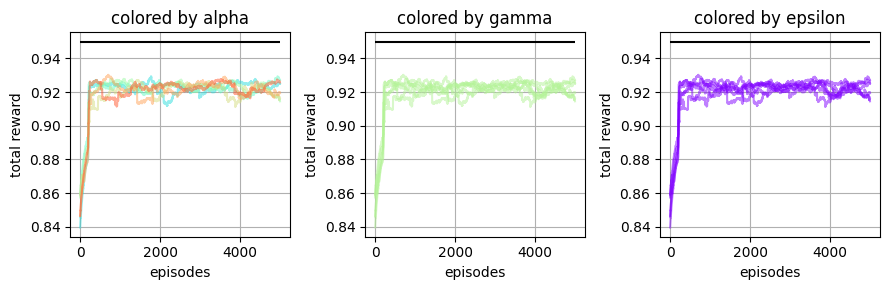

In [28]:
cap_at = 5000

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))

axes[0].set_title('colored by alpha')
axes[1].set_title('colored by gamma')
axes[2].set_title('colored by epsilon')

for ax in axes:
    ax.grid()
    ax.hlines(highest_reward_2d, 0, cap_at, color='black', label='optimal')
    ax.set_xlabel('episodes')
    ax.set_ylabel('total reward')

for i in range(3, 9):
    for j in range(6, 7):
        for k in range(1):
            axes[0].plot(total_reward_smooth[i, j, k, :cap_at], label=f'agent {i+1}', c=colors10[i], alpha=0.5)
            axes[1].plot(total_reward_smooth[i, j, k, :cap_at], label=f'agent {i+1}', c=colors11[j], alpha=0.5)
            axes[2].plot(total_reward_smooth[i, j, k, :cap_at], label=f'agent {i+1}', c=colors11[k], alpha=0.5)

fig.tight_layout()
plt.show()

In conclusion, we see again that we don't need exploration in this environment, that it even is harmful to performance. This might be due to the small state space. For gamma, non-extrem values around 0.5 perform best, whereas for alpha values just should not be too small for convergence.